# Exploring Neural Networks for Text Classification Tasks

## Part 1: Exploratory Data Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import collections
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split

warnings.filterwarnings("ignore")

- Classes and distribution in the dataset:

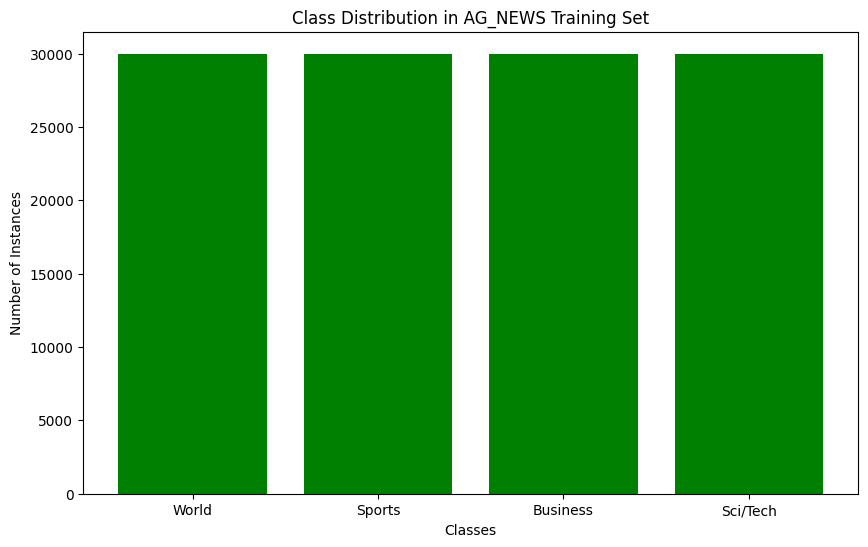

In [5]:
from torchtext.datasets import AG_NEWS #Importing Dataset

#Dividing the data into train and test
train_iter, test_iter = AG_NEWS(split=('train', 'test'))

class_names = {
    1: 'World',
    2: 'Sports',
    3: 'Business',
    4: 'Sci/Tech'
}

# Convert train_iter and test_iter to a list
train_list = list(train_iter)
test_list = list(test_iter)

# Extract labels from the training data
labels = [label for (label, _) in train_list]

# Initialize a dictionary to count the number of instances per class
label_counts = {}
for label in labels:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Prepare data for plotting
classes = [class_names[label] for label in sorted(label_counts.keys())]
counts = [label_counts[label] for label in sorted(label_counts.keys())]

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='green')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in AG_NEWS Training Set')

warnings.filterwarnings("ignore")

- Distribution of the text lengths:

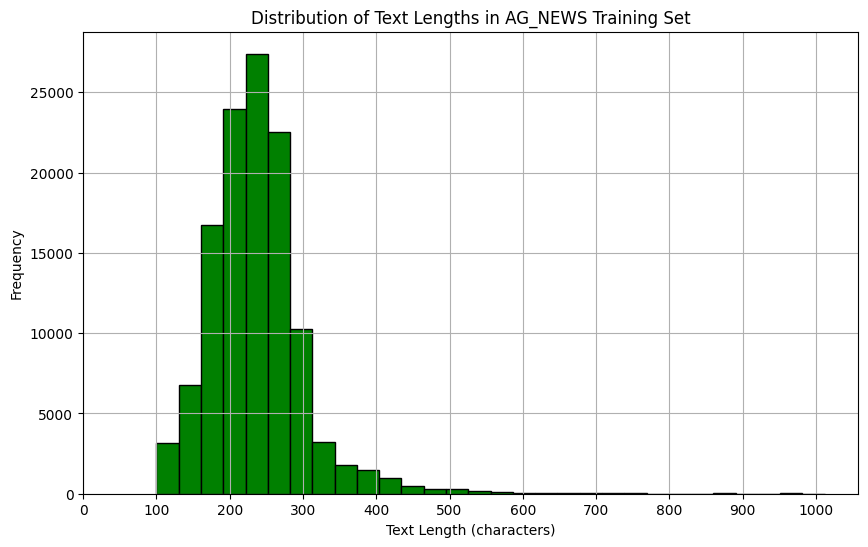

In [6]:
# Calculate the length of each text sample (characters)
text_lengths = [len(text) for (_, text) in train_list]

# Plot a histogram to visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='green', edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in AG_NEWS Training Set')
plt.grid(True)
plt.xticks(range(0, max(text_lengths), 100))

warnings.filterwarnings("ignore")

- Most Common words in the dataset

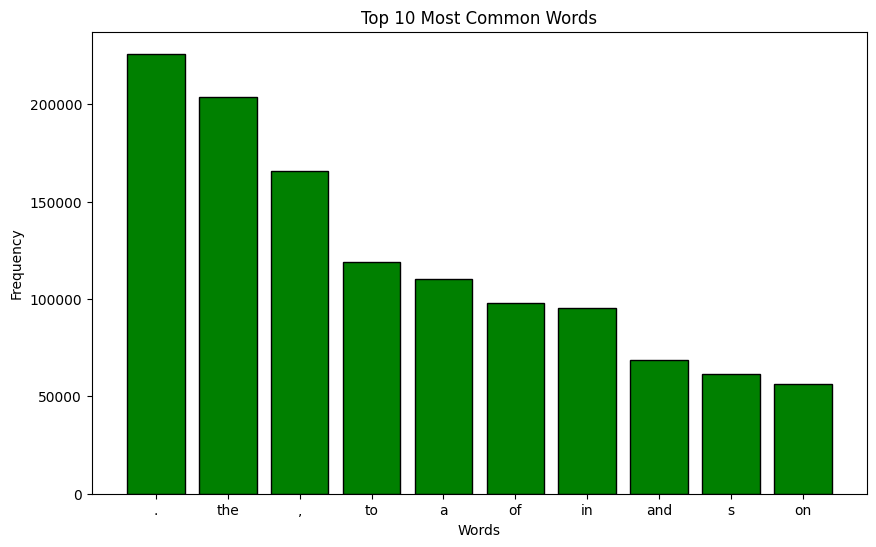

In [7]:
# Initialize counter and tokenizer
counter = collections.Counter()
tokenizer = get_tokenizer("basic_english")

# Count words and tokenize in each line of train_list
for (label, line) in train_list:
    counter.update(tokenizer(line))

# Get the 10 most common words and their frequencies
most_common_words = counter.most_common(10)
words, frequencies = zip(*most_common_words)

# Plot the most common words and their frequencies
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='green', edgecolor='black')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')

warnings.filterwarnings("ignore")

- Lenght of training and test set

In [8]:
print("The length of the training set is: ", len(train_list),'samples')
print("The length of the test set is: ", len(test_list),'samples')

The length of the training set is:  120000 samples
The length of the test set is:  7600 samples


## Part 2: Preprocessing

In [9]:
import torch
import nltk
import re

from torchtext.vocab import build_vocab_from_iterator

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

##### Text Normalization, Tokenization and Stemming & Lemmatization:


In [10]:
# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a preprocessing function
def preprocess_text(text):
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text into words
    tokens = tokenizer(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    if not tokens:
        tokens = ['<pad>']
    
    return tokens


# Apply preprocessing to the training data
preprocessed_train_list = [
    (label, preprocess_text(text)) for (label, text) in train_list
]

# Apply preprocessing to the testing data
preprocessed_test_list = [
    (label, preprocess_text(text)) for (label, text) in test_list
]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Build the Vocabulary:

In [11]:
# Define special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'


def build_vocab(preprocessed_data, max_vocab_size=20000, min_freq=1):
    def yield_tokens(data_iter):
        for _, tokens in data_iter:
            yield tokens

    vocab_obj = build_vocab_from_iterator(
        yield_tokens(preprocessed_data),
        min_freq=min_freq,
        specials=[PAD_TOKEN, UNK_TOKEN],
        max_tokens=max_vocab_size
    )
    vocab_obj.set_default_index(vocab_obj[UNK_TOKEN])
    return vocab_obj

# Build the vocabulary
vocab_train = build_vocab(preprocessed_train_list, max_vocab_size=20000, min_freq=1)

#### Embedding initialization with GloVe pretrained model:

In [12]:
import gensim.downloader as api

glove_model = api.load('glove-wiki-gigaword-50')

In [13]:
# Define embedding dimensions
embedding_dim = glove_model.vector_size

# Initialize the embedding matrix with random numbers
embedding_matrix = np.random.uniform(-0.25, 0.25, (len(vocab_train), embedding_dim))

# Replace random vectors with pre-trained vectors where available
pretrained_found = 0
for word, idx in vocab_train.get_stoi().items():
    if word in glove_model:
        embedding_matrix[idx] = glove_model[word]
        pretrained_found += 1

# Convert the embedding matrix to a PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Number of pre-trained embeddings found: {pretrained_found} out of {len(vocab_train)} words")

Embedding matrix shape: torch.Size([20000, 50])
Number of pre-trained embeddings found: 12737 out of 20000 words


## Part 3: Neural Networks for Text Classification


- Preparation of the Data Loaders:

In [14]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Create a custom Dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, data_list, vocab):
        self.data_list = data_list
        self.vocab = vocab
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        label, tokens = self.data_list[idx]
        # Convert label to zero-based index
        label = label - 1
        
        # Convert tokens to indices
        indices = [self.vocab[token] for token in tokens]
        return torch.tensor(indices, dtype=torch.long), label

# Creation of train and test datasets
train_dataset = TextClassificationDataset(preprocessed_train_list, vocab_train)
test_dataset = TextClassificationDataset(preprocessed_test_list, vocab_train)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define a collate function for padding sequences
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (seq, label) in batch:
        label_list.append(label)
        lengths.append(len(seq))
        text_list.append(seq)
    # Pad sequences
    padded_text = pad_sequence(text_list, batch_first=True, padding_value=vocab_train[PAD_TOKEN])
    labels = torch.tensor(label_list, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return padded_text, lengths, labels

# Creation of DataLoaders
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

#### Definition of the Neural Networks:

- Simple Neural Network (Feedforward NN)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNNClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, embedding_matrix, hidden_dim, dropout_prob=0.5):
        super(SimpleNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Compute the average of embeddings over the sequence length
        embedded = embedded.mean(dim=1)
        hidden_out = F.relu(self.hidden(embedded))
        hidden_out = self.dropout(hidden_out)  # Apply Dropout
        out = self.fc(hidden_out)
        return out

- RNN Model:

In [16]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, embedding_matrix, dropout_prob=0.5):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)
        hidden = self.dropout(hidden.squeeze(0))  # Apply dropout
        out = self.fc(hidden)
        return out


- LSTM Model

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, embedding_matrix, dropout_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed_embedded)
        # hidden: [1, batch_size, hidden_dim]
        hidden = self.dropout(hidden.squeeze(0))  # Apply dropout
        out = self.fc(hidden)  # [batch_size, num_classes]
        return out


#### Training and Evaluation Functions:

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.train()
    total_steps = len(train_loader)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (texts, lengths, labels) in enumerate(train_loader):
            texts = texts.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)
            
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for texts, lengths, labels in val_loader:
                texts = texts.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                outputs = model(texts, lengths)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
    
    return history

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for texts, lengths, labels in test_loader:
            texts = texts.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device)
            outputs = model(texts, lengths)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Obtaining confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Obtaining classification report
    report = classification_report(all_labels, all_preds, 
                                 target_names=class_names.values(),
                                 output_dict=True)
    
    return accuracy, cm, report


def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


#### Train and evaluation of the models:

In [20]:
num_classes = 4
embedding_dim = embedding_matrix.shape[1]
hidden_dim = 64
num_epochs = 15
results = {}

- Training of the FFNN:


Training Simple NN...
Epoch [1/15], Train Loss: 0.9864, Train Acc: 67.35%, Val Loss: 0.5914, Val Acc: 83.22%
Epoch [2/15], Train Loss: 0.5360, Train Acc: 83.07%, Val Loss: 0.4486, Val Acc: 85.57%
Epoch [3/15], Train Loss: 0.4496, Train Acc: 85.62%, Val Loss: 0.4033, Val Acc: 87.01%
Epoch [4/15], Train Loss: 0.4072, Train Acc: 87.19%, Val Loss: 0.3765, Val Acc: 87.79%
Epoch [5/15], Train Loss: 0.3778, Train Acc: 88.11%, Val Loss: 0.3564, Val Acc: 88.38%
Epoch [6/15], Train Loss: 0.3534, Train Acc: 88.90%, Val Loss: 0.3413, Val Acc: 88.88%
Epoch [7/15], Train Loss: 0.3346, Train Acc: 89.51%, Val Loss: 0.3295, Val Acc: 89.15%
Epoch [8/15], Train Loss: 0.3193, Train Acc: 89.90%, Val Loss: 0.3201, Val Acc: 89.42%
Epoch [9/15], Train Loss: 0.3050, Train Acc: 90.35%, Val Loss: 0.3124, Val Acc: 89.63%
Epoch [10/15], Train Loss: 0.2944, Train Acc: 90.78%, Val Loss: 0.3062, Val Acc: 89.79%
Epoch [11/15], Train Loss: 0.2832, Train Acc: 91.13%, Val Loss: 0.3010, Val Acc: 89.92%
Epoch [12/15], Tra

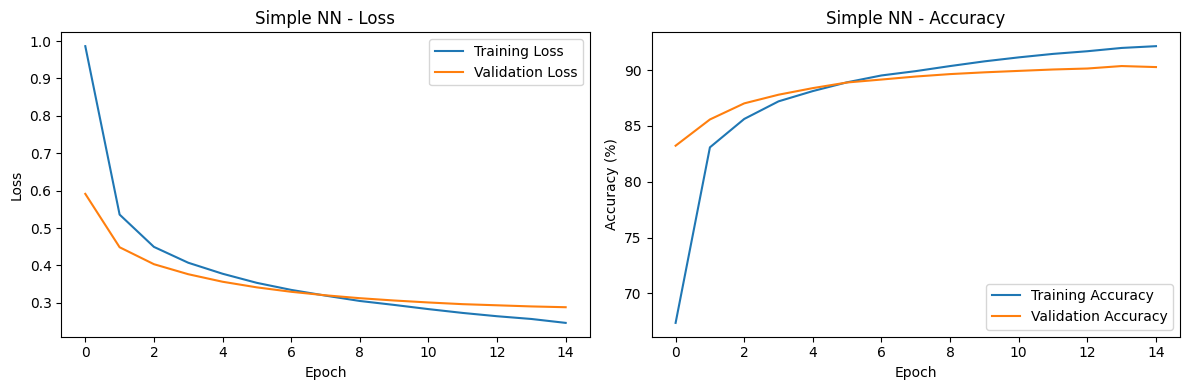

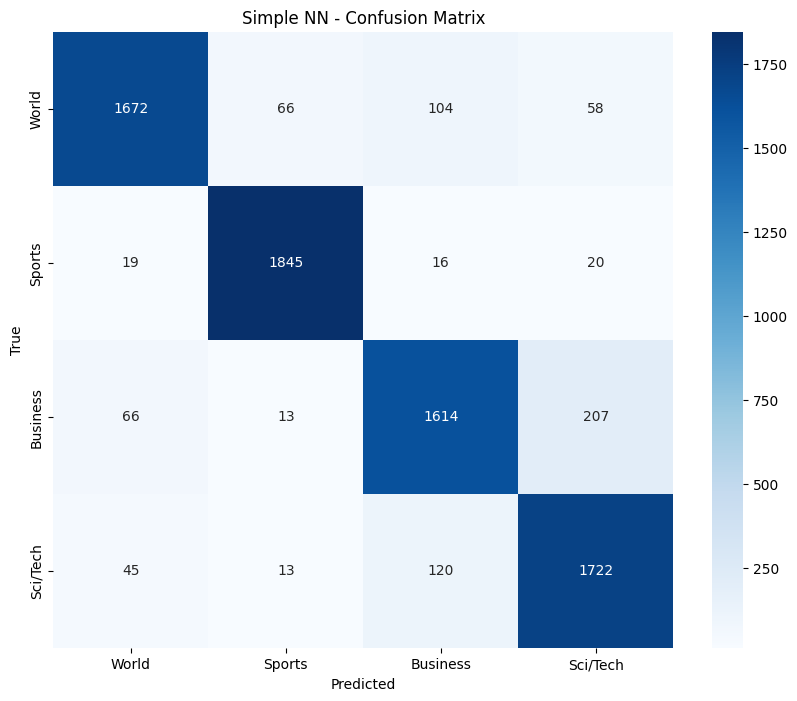


Simple NN - Classification Report:
              precision    recall  f1-score      support
World          0.927858  0.880000  0.903296  1900.000000
Sports         0.952504  0.971053  0.961689  1900.000000
Business       0.870550  0.849474  0.859883  1900.000000
Sci/Tech       0.857997  0.906316  0.881495  1900.000000
accuracy       0.901711  0.901711  0.901711     0.901711
macro avg      0.902227  0.901711  0.901590  7600.000000
weighted avg   0.902227  0.901711  0.901590  7600.000000


In [21]:
model1 = SimpleNNClassifier(embedding_dim, num_classes, embedding_matrix, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.00015)
print("\nTraining Simple NN...")
history = train_model(model1, train_loader, val_loader, criterion, optimizer, num_epochs)
accuracy, cm, report = evaluate_model(model1, test_loader)

results['Simple NN'] = {
    'history': history,
    'accuracy': accuracy,
    'confusion_matrix': cm,
    'classification_report': report
}

#Graphical representation of the training history
plt.figure(figsize=(12, 4))

#loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Simple NN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#precission plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Simple NN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

#Confusion matrix and classification report
plot_confusion_matrix(cm, "Simple NN")
print("\nSimple NN - Classification Report:")
report_df = pd.DataFrame(report).transpose()
print(report_df)

- Training of the RNN model:


Training RNN...
Epoch [1/15], Train Loss: 0.5736, Train Acc: 78.36%, Val Loss: 0.3425, Val Acc: 89.57%
Epoch [2/15], Train Loss: 0.2800, Train Acc: 91.88%, Val Loss: 0.3299, Val Acc: 89.98%
Epoch [3/15], Train Loss: 0.2593, Train Acc: 92.31%, Val Loss: 0.3228, Val Acc: 89.93%
Epoch [4/15], Train Loss: 0.2467, Train Acc: 92.63%, Val Loss: 0.3214, Val Acc: 89.95%
Epoch [5/15], Train Loss: 0.2360, Train Acc: 92.98%, Val Loss: 0.3119, Val Acc: 90.12%
Epoch [6/15], Train Loss: 0.2271, Train Acc: 93.16%, Val Loss: 0.3102, Val Acc: 90.23%
Epoch [7/15], Train Loss: 0.2190, Train Acc: 93.39%, Val Loss: 0.3096, Val Acc: 90.32%
Epoch [8/15], Train Loss: 0.2118, Train Acc: 93.57%, Val Loss: 0.3093, Val Acc: 90.34%
Epoch [9/15], Train Loss: 0.2035, Train Acc: 93.78%, Val Loss: 0.3106, Val Acc: 90.30%
Epoch [10/15], Train Loss: 0.1962, Train Acc: 94.02%, Val Loss: 0.3142, Val Acc: 90.16%
Epoch [11/15], Train Loss: 0.1909, Train Acc: 94.18%, Val Loss: 0.3101, Val Acc: 90.34%
Epoch [12/15], Train Los

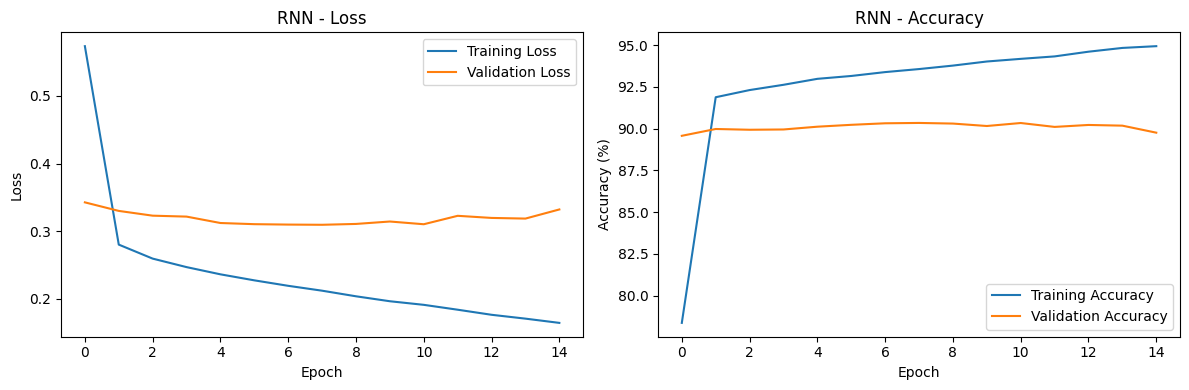

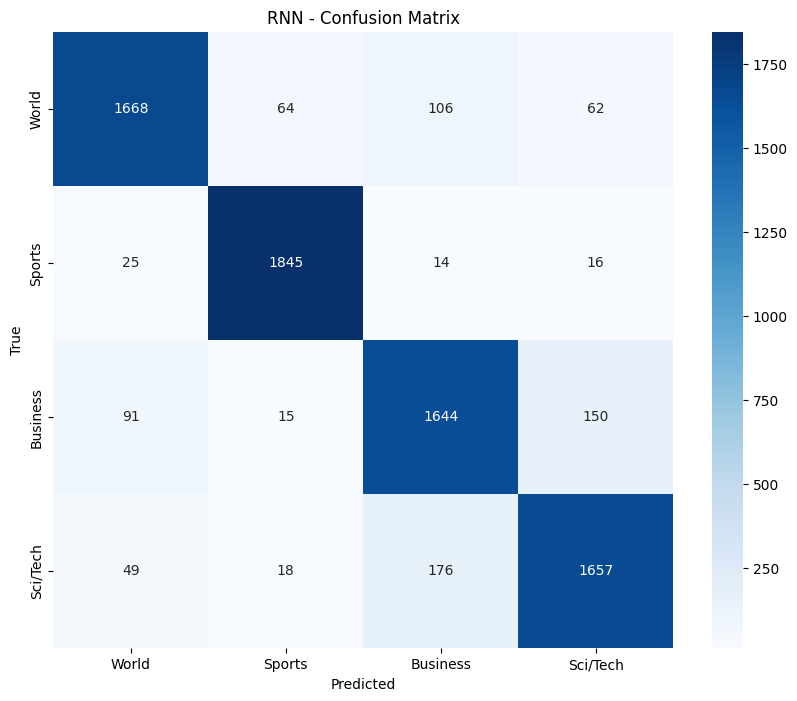


RNN - Classification Report:
              precision    recall  f1-score      support
World          0.909984  0.877895  0.893651  1900.000000
Sports         0.950051  0.971053  0.960437  1900.000000
Business       0.847423  0.865263  0.856250  1900.000000
Sci/Tech       0.879045  0.872105  0.875561  1900.000000
accuracy       0.896579  0.896579  0.896579     0.896579
macro avg      0.896626  0.896579  0.896475  7600.000000
weighted avg   0.896626  0.896579  0.896475  7600.000000


In [22]:
model2 = RNNClassifier(embedding_dim, hidden_dim, num_classes, embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
print("\nTraining RNN...")
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs)
accuracy, cm, report = evaluate_model(model2, test_loader)

results['RNN'] = {
    'history': history,
    'accuracy': accuracy,
    'confusion_matrix': cm,
    'classification_report': report
}

# Gráficas de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Plot de pérdida
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('RNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot de precisión
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('RNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Matriz de confusión
plot_confusion_matrix(cm, "RNN")
print("\nRNN - Classification Report:")
report_df = pd.DataFrame(report).transpose()
print(report_df)

- Training of the LSTM model:


Training LSTM...
Epoch [1/15], Train Loss: 0.5062, Train Acc: 84.47%, Val Loss: 0.3218, Val Acc: 89.97%
Epoch [2/15], Train Loss: 0.2406, Train Acc: 92.95%, Val Loss: 0.3033, Val Acc: 90.30%
Epoch [3/15], Train Loss: 0.2127, Train Acc: 93.64%, Val Loss: 0.2995, Val Acc: 90.36%
Epoch [4/15], Train Loss: 0.1948, Train Acc: 94.06%, Val Loss: 0.2996, Val Acc: 90.35%
Epoch [5/15], Train Loss: 0.1828, Train Acc: 94.41%, Val Loss: 0.3046, Val Acc: 90.30%
Epoch [6/15], Train Loss: 0.1730, Train Acc: 94.71%, Val Loss: 0.3032, Val Acc: 90.39%
Epoch [7/15], Train Loss: 0.1626, Train Acc: 95.06%, Val Loss: 0.3148, Val Acc: 90.15%
Epoch [8/15], Train Loss: 0.1544, Train Acc: 95.30%, Val Loss: 0.3240, Val Acc: 90.08%
Epoch [9/15], Train Loss: 0.1481, Train Acc: 95.50%, Val Loss: 0.3289, Val Acc: 90.00%
Epoch [10/15], Train Loss: 0.1407, Train Acc: 95.66%, Val Loss: 0.3312, Val Acc: 89.97%
Epoch [11/15], Train Loss: 0.1339, Train Acc: 95.93%, Val Loss: 0.3389, Val Acc: 89.82%
Epoch [12/15], Train Lo

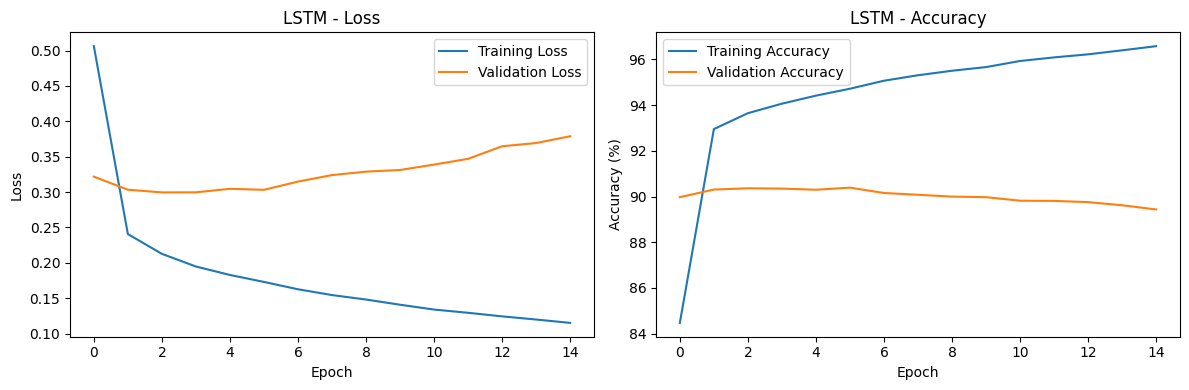

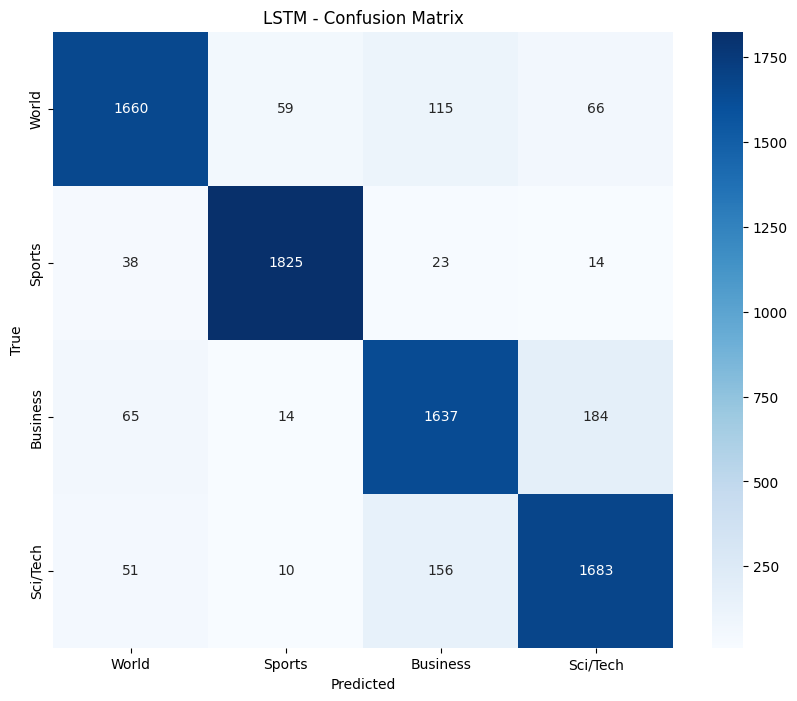


LSTM - Classification Report:
              precision    recall  f1-score      support
World          0.915105  0.873684  0.893915  1900.000000
Sports         0.956499  0.960526  0.958508  1900.000000
Business       0.847747  0.861579  0.854607  1900.000000
Sci/Tech       0.864407  0.885789  0.874968  1900.000000
accuracy       0.895395  0.895395  0.895395     0.895395
macro avg      0.895939  0.895395  0.895499  7600.000000
weighted avg   0.895939  0.895395  0.895499  7600.000000


In [23]:
model3 = LSTMClassifier(embedding_dim, hidden_dim, num_classes, embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)
print("\nTraining LSTM...")
history = train_model(model3, train_loader, val_loader, criterion, optimizer, num_epochs)
accuracy, cm, report = evaluate_model(model3, test_loader)

results['LSTM'] = {
    'history': history,
    'accuracy': accuracy,
    'confusion_matrix': cm,
    'classification_report': report
}

# Gráficas de entrenamiento y validación
plt.figure(figsize=(12, 4))

# Plot de pérdida
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('LSTM - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot de precisión
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('LSTM - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Matriz de confusión
plot_confusion_matrix(cm, "LSTM")
print("\nLSTM - Classification Report:")
report_df = pd.DataFrame(report).transpose()
print(report_df)

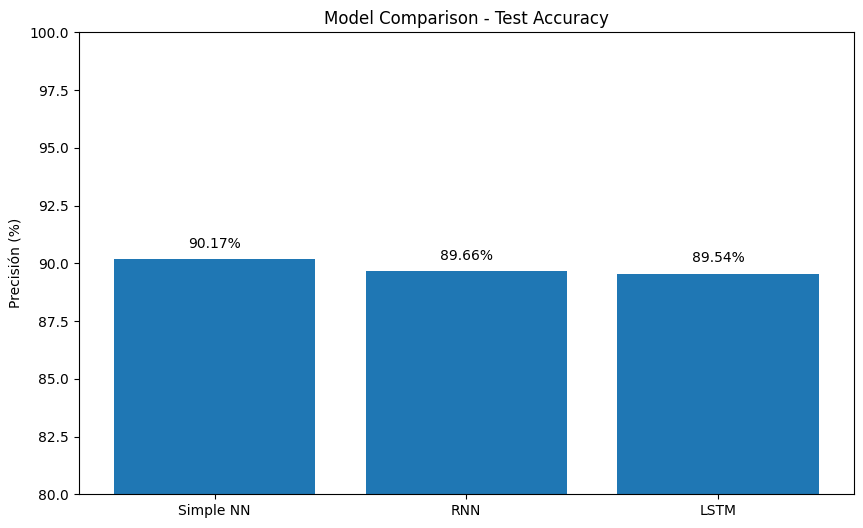

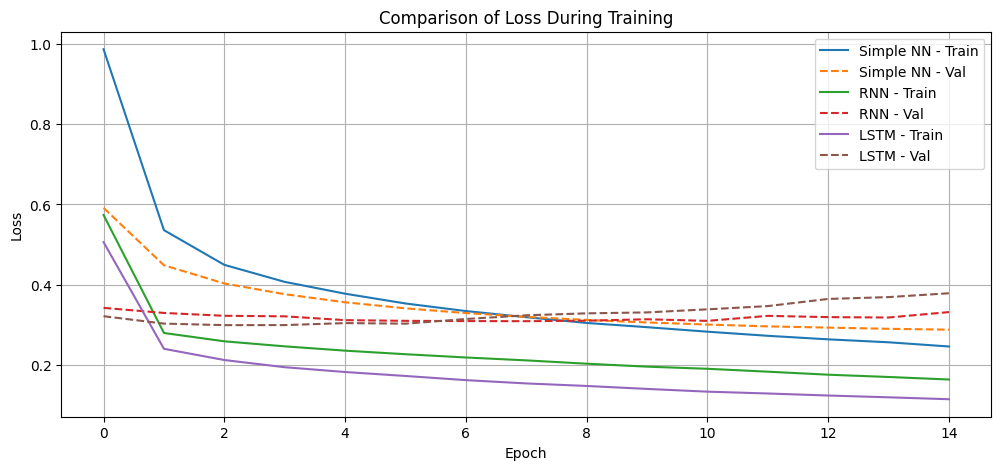

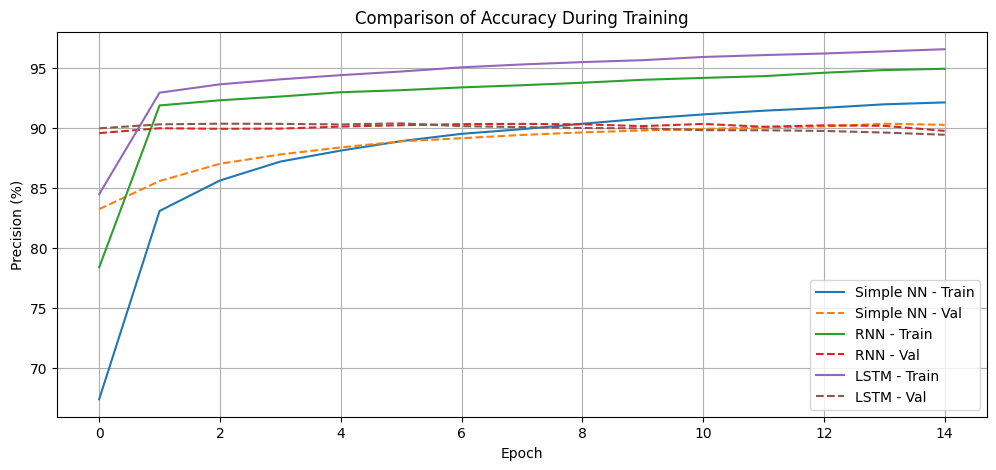


Comparison Table of Metrics:
           Accuracy  Precision (weighted)  Recall (weighted)  \
Simple NN     90.17                 90.22              90.17   
RNN           89.66                 89.66              89.66   
LSTM          89.54                 89.59              89.54   

           F1-score (weighted)  
Simple NN                90.16  
RNN                      89.65  
LSTM                     89.55  


In [26]:
#final comparison 
models = {
    'Simple NN': model1,
    'RNN': model2,
    'LSTM': model3
}

#precission comparison
accuracies = [results[name]['accuracy'] for name in models.keys()]
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies)
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Precisión (%)')
plt.ylim(80, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')
plt.show()

#comparison of loss during training
plt.figure(figsize=(12, 5))
for name in models.keys():
    plt.plot(results[name]['history']['train_loss'], label=f'{name} - Train')
    plt.plot(results[name]['history']['val_loss'], label=f'{name} - Val', linestyle='--')
plt.title('Comparison of Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#comparison of accuracy during training
plt.figure(figsize=(12, 5))
for name in models.keys():
    plt.plot(results[name]['history']['train_acc'], label=f'{name} - Train')
    plt.plot(results[name]['history']['val_acc'], label=f'{name} - Val', linestyle='--')
plt.title('Comparison of Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.legend()
plt.grid(True)
plt.show()

#cpmparison of confusion matrix
comparison_data = {
    'Accuracy': [],
    'Precision (weighted)': [],
    'Recall (weighted)': [],
    'F1-score (weighted)': []
}

for name in models.keys():
    report = results[name]['classification_report']
    comparison_data['Accuracy'].append(results[name]['accuracy'])
    comparison_data['Precision (weighted)'].append(report['weighted avg']['precision'] * 100)
    comparison_data['Recall (weighted)'].append(report['weighted avg']['recall'] * 100)
    comparison_data['F1-score (weighted)'].append(report['weighted avg']['f1-score'] * 100)

comparison_df = pd.DataFrame(comparison_data, index=models.keys())
print("\nComparison Table of Metrics:")
print(comparison_df.round(2))